
## Dask - Executing a Process Workflow with Big Data

### 1. Data Gathering (6pts)

#### a) Download the parking violations dataset for 2017 - 2022 (≈13GB) from the following website https://data.cityofnewyork.us/browse?q=parking+violations


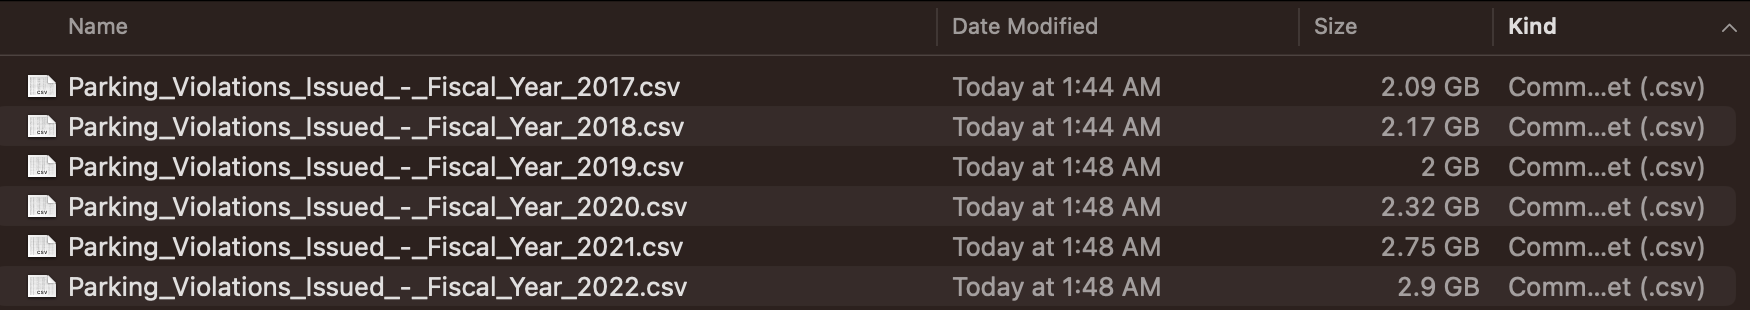

#### (b) Store all the CSV data in a single AWS S3 bucket via the AWS Academy Learner Lab (Big Data Containers) class. You may manually upload the data or use the code provided in the S3 tutorial to upload the data to the bucket

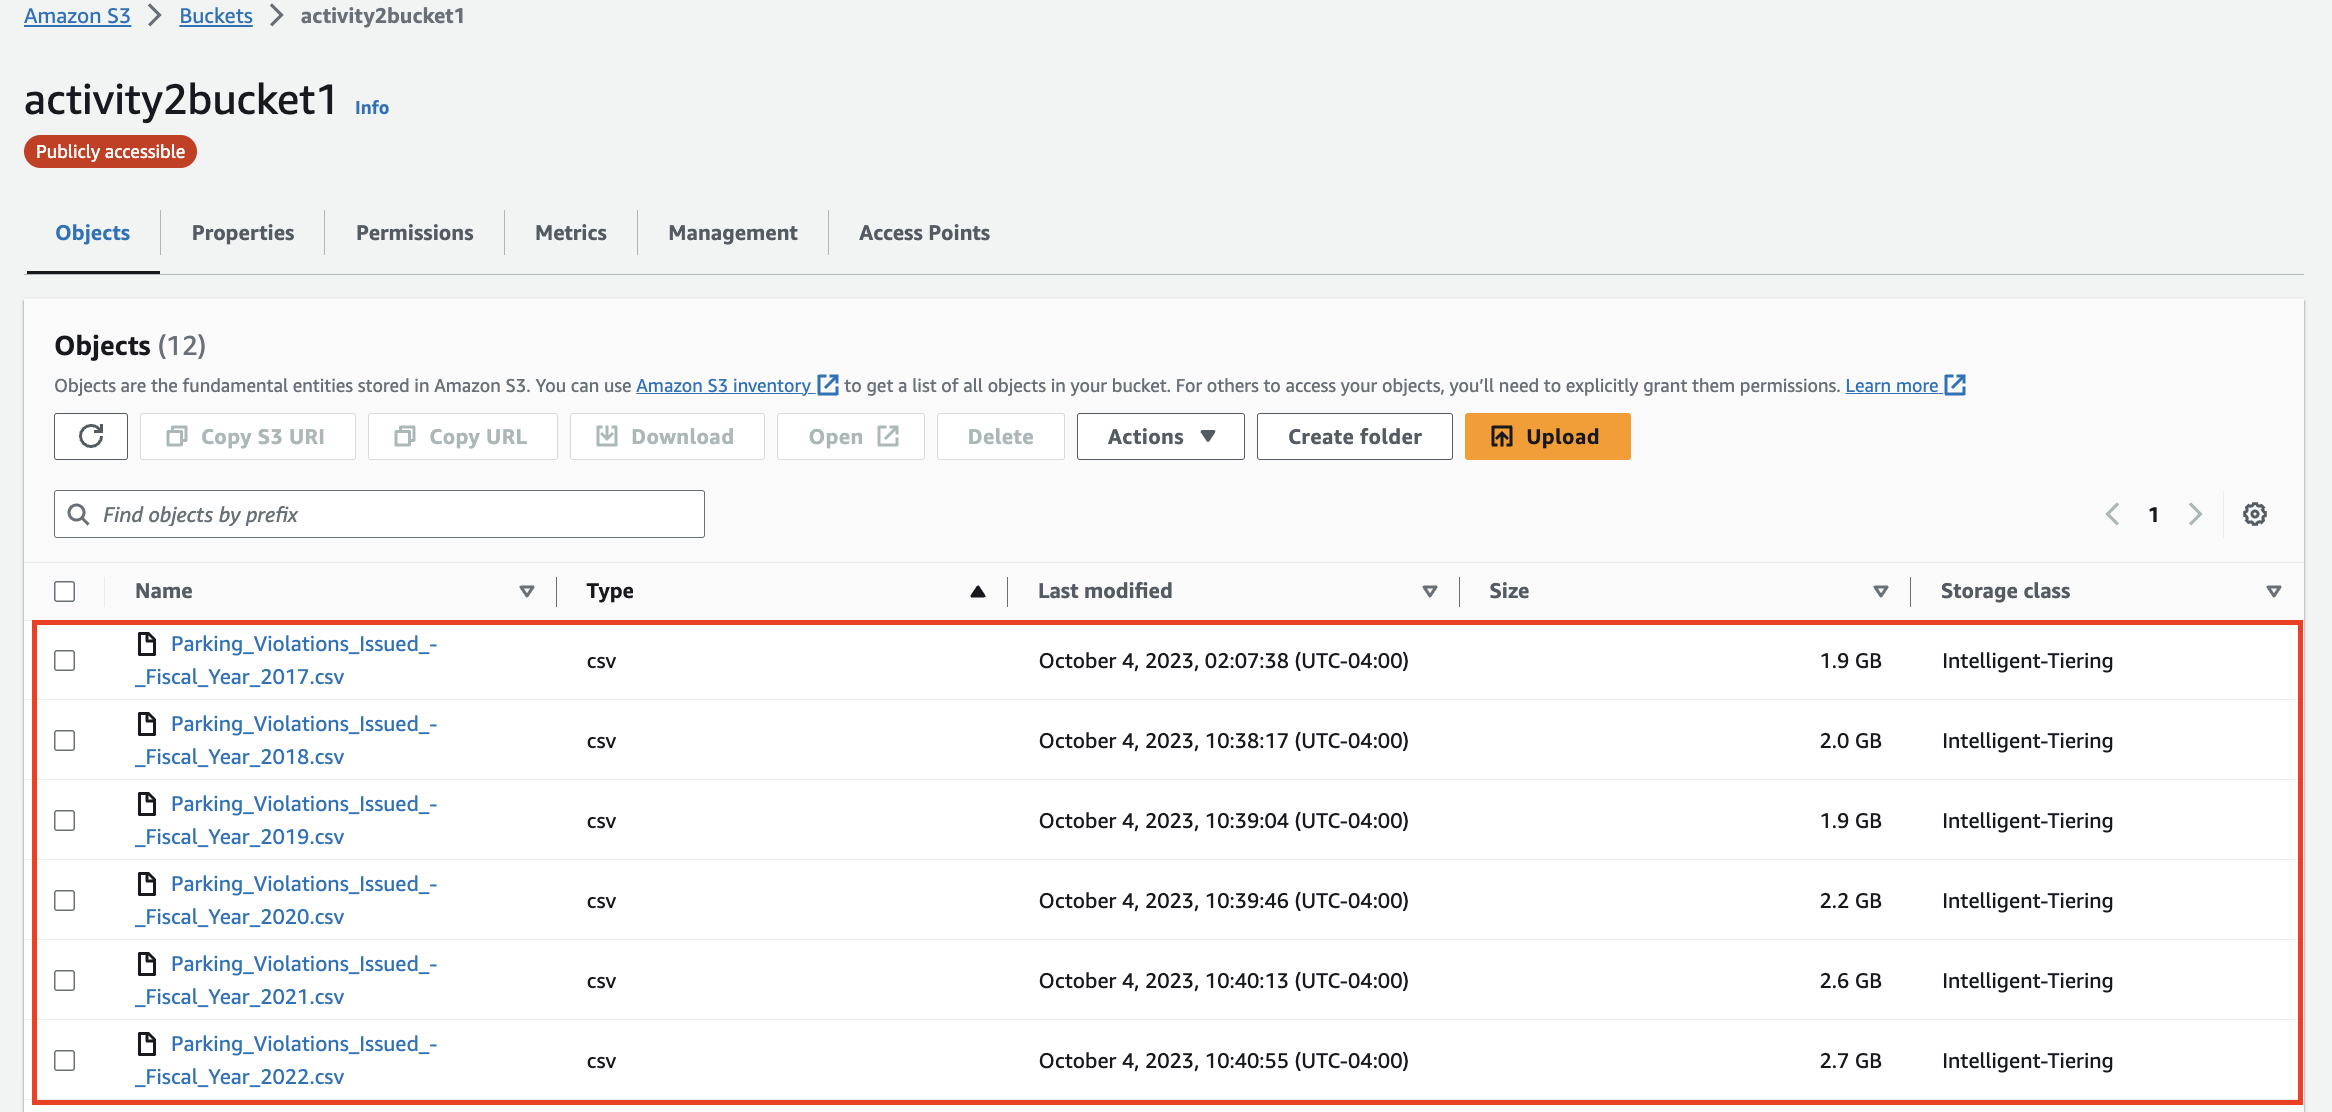

#### (c) Create a second bucket that will store the intermediate steps of your work as parquet files.

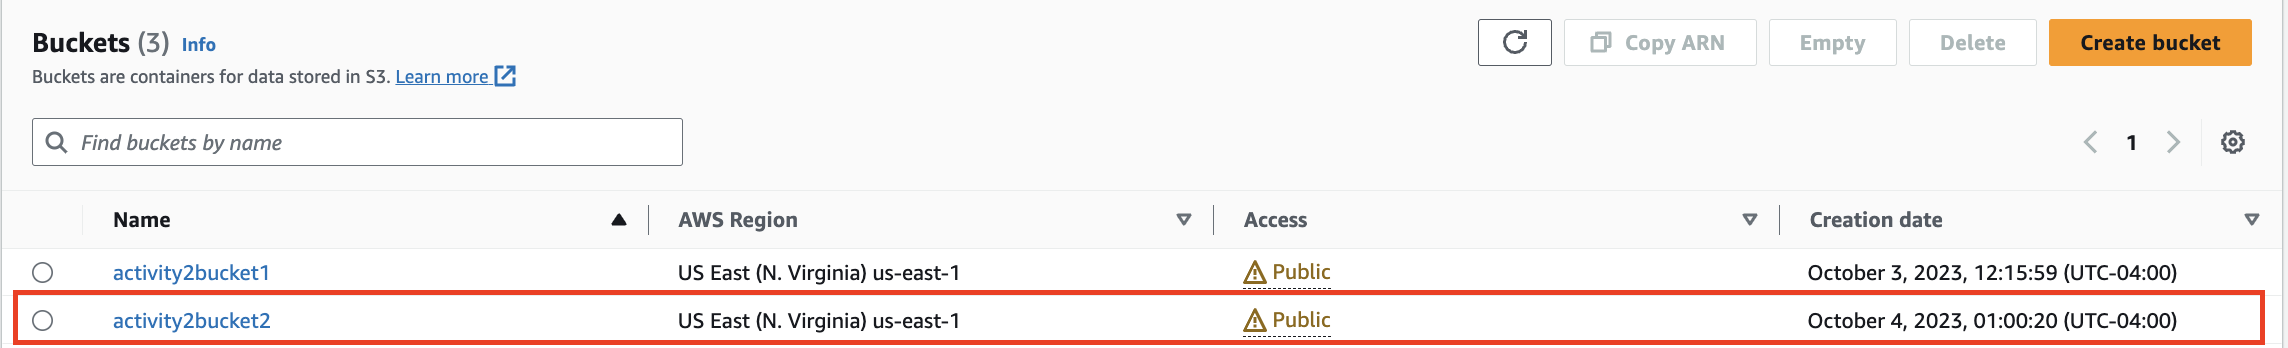

### 2. Data Cleaning (15pts - 1pt per problem except 4pts for part a.)

#### (a) Load the data from your S3 bucket into dask using a cluster (eg. Saturn Cloud or AWS ECS)

In [ ]:
from dask_saturn import SaturnCluster    #importing modules
from dask.distributed import Client
import dask.dataframe as dd
import os
import seaborn as sns
import numpy as np
import pandas as pd
from functools import reduce
from dask.diagnostics import ProgressBar, progress
from matplotlib import pyplot as plt

In [4]:
credentials_path='./aws_credentials.txt'   
os.environ['region_name']='us-east-1'
with open(credentials_path) as aws_credentials:    # accessing the credentials
    for line in aws_credentials:
        if "=" in line:
            key,val=line.split("=",1)
            os.environ[key.strip().upper()]=val.strip()

In [2]:
cluster=SaturnCluster()       # initializing dask cluster
client=Client(cluster)
client

INFO:dask-saturn:Cluster is ready
INFO:dask-saturn:Registering default plugins
INFO:dask-saturn:Success!


<Client: 'tcp://192.168.42.196:8786' processes=1 threads=2, memory=14.44 GiB>

In [2]:
s3_path_17='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2017.csv'
s3_path_18='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2018.csv'
s3_path_19='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2019.csv'
s3_path_20='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2020.csv'
s3_path_21='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2021.csv'
s3_path_22='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2022.csv'

#Loading data from S3 bucket
data_17=dd.read_csv(s3_path_17,storage_options={'anon':True},dtype=dtype)
data_18=dd.read_csv(s3_path_18,storage_options={'anon':True},dtype=dtype)
data_19=dd.read_csv(s3_path_19,storage_options={'anon':True},dtype=dtype)
data_20=dd.read_csv(s3_path_20,storage_options={'anon':True},dtype=dtype)
data_21=dd.read_csv(s3_path_21,storage_options={'anon':True},dtype=dtype)
data_22=dd.read_csv(s3_path_22,storage_options={'anon':True},dtype=dtype)

In [27]:
data_17.columns   # columns in the dataset

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

#### (b) Find the common columns between each dataset.

In [28]:
columns = [set(data_17.columns),set(data_18.columns),set(data_19.columns),set(data_20.columns),set(data_21.columns),set(data_22.columns)]
common_columns = list(reduce(lambda a, i: a.intersection(i), columns))

In [29]:
common_columns   # common columns

['Meter Number',
 'To Hours In Effect',
 'Double Parking Violation',
 'Issue Date',
 'Vehicle Expiration Date',
 'Feet From Curb',
 'Date First Observed',
 'Violation Description',
 'Violation Legal Code',
 'Law Section',
 'Street Code3',
 'Street Code2',
 'Sub Division',
 'Issuer Precinct',
 'Violation County',
 'Violation Post Code',
 'Street Name',
 'Issuer Command',
 'Street Code1',
 'From Hours In Effect',
 'Plate ID',
 'Issuing Agency',
 'Vehicle Make',
 'Violation Precinct',
 'Issuer Code',
 'No Standing or Stopping Violation',
 'Violation Location',
 'Violation Time',
 'Violation In Front Of Or Opposite',
 'Vehicle Year',
 'Registration State',
 'Unregistered Vehicle?',
 'Summons Number',
 'Intersecting Street',
 'Hydrant Violation',
 'House Number',
 'Vehicle Color',
 'Violation Code',
 'Time First Observed',
 'Vehicle Body Type',
 'Issuer Squad',
 'Plate Type']

#### (c) Either create your own meaningful schema based on the common columns in the dataset or use the schema presented on the slides

In [30]:
dtypes = {
'Date First Observed': np.str_,
# 'Days Parking In Effect': np.str_,
'Double Parking Violation': np.str_,
'Feet From Curb': np.float32,
'From Hours In Effect': np.str_,
'House Number': np.str_,
'Hydrant Violation': np.str_,
'Intersecting Street': np.str_,
'Issue Date': np.str_,
'Issuer Code': np.float32,
'Issuer Command': np.str_,
'Issuer Precinct': np.float32,
'Issuer Squad': np.str_,
'Issuing Agency': np.str_,
'Law Section': np.float32,
'Meter Number': np.str_,
'No Standing or Stopping Violation': np.str_,
'Plate ID': np.str_,
'Plate Type': np.str_,
'Registration State': np.str_,
'Street Code1': np.uint32,
'Street Code2': np.uint32,
'Street Code3': np.uint32,
'Street Name': np.str_,
'Sub Division': np.str_,
'Summons Number': np.uint32,
'Time First Observed': np.str_,
'To Hours In Effect': np.str_,
'Unregistered Vehicle?': np.str_,
'Vehicle Body Type': np.str_,
'Vehicle Color': np.str_,
'Vehicle Expiration Date': np.str_,
'Vehicle Make': np.str_,
'Vehicle Year': np.float32,
'Violation Code': np.uint16,
'Violation County': np.str_,
'Violation Description': np.str_,
'Violation In Front Of Or Opposite': np.str_,
'Violation Legal Code': np.str_,
'Violation Location': np.str_,
'Violation Post Code': np.str_,
'Violation Precinct': np.float32,
'Violation Time': np.str_
}

In [32]:
s3_path_17='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2017.csv'
s3_path_18='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2018.csv'
s3_path_19='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2019.csv'
s3_path_20='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2020.csv'
s3_path_21='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2021.csv'
s3_path_22='s3://activity2bucket1/Parking_Tickets/Parking_Violations_Issued_-_Fiscal_Year_2022.csv'
file_list=[]
file_list.append(s3_path_17)
file_list.append(s3_path_18)
file_list.append(s3_path_19)
file_list.append(s3_path_20)
file_list.append(s3_path_21)
file_list.append(s3_path_22)

# Creating dataset with common columns
data = dd.concat([dd.read_csv(f,storage_options={'anon':True}, dtype=dtypes,usecols=common_columns) for f in file_list])

In [33]:
data.reset_index(drop=True).to_parquet('s3://cse4510-act2-group3/data', compression='snappy')

In [3]:
data = dd.read_parquet('s3://cse4510-act2-group3/data/*.parquet', engine="pyarrow")

#### (d) Find the percentage of missing values in the dataset

In [4]:
missing_values = data.isnull().sum()
percent_missing = ((missing_values / data.index.size) * 100).compute()
percent_missing

Summons Number                         0.000000
Plate ID                               0.002363
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000395
Violation Code                         0.000000
Vehicle Body Type                      0.328477
Vehicle Make                           0.417966
Issuing Agency                         0.000003
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    27.862938
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        27.621132
Issuer Squad                          28.241973
Violation Time                         0.001238
Time First Observed                   94

#### (e) Drop columns with missing values >=50%

In [6]:
columns_to_drop = list(percent_missing[percent_missing >= 50].index)
print(f'{len(columns_to_drop)} columns to drop')
columns_to_drop

10 columns to drop


['Time First Observed',
 'Intersecting Street',
 'Violation Legal Code',
 'From Hours In Effect',
 'To Hours In Effect',
 'Unregistered Vehicle?',
 'Meter Number',
 'No Standing or Stopping Violation',
 'Hydrant Violation',
 'Double Parking Violation']

In [7]:
data_clean_stage1 = data.drop(columns_to_drop, axis=1)
print(f'Total {len(data_clean_stage1.columns)} columns after dropping')
data_clean_stage1.columns

Total 32 columns after dropping


Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Date First Observed', 'Law Section', 'Sub Division', 'Vehicle Color',
       'Vehicle Year', 'Feet From Curb', 'Violation Post Code',
       'Violation Description'],
      dtype='object')

#### (f) Impute the most common vehicle color into the records that are missing a vehicle color

In [11]:
count_of_vehicle_colors = data_clean_stage1['Vehicle Color'].value_counts().compute()
print('Count of different Vehicle colors')
print(count_of_vehicle_colors)

Count of different Vehicle colors
WH       13715217
GY       13682447
BK       12071282
WHITE     7069451
BL        4670252
           ...   
HAROO           1
HAZOO           1
HBLUE           1
HC              1
white           1
Name: Vehicle Color, Length: 5024, dtype: int64


In [12]:
most_common_color = count_of_vehicle_colors.sort_values(ascending=False).index[0]
print(f'{most_common_color} is most_common_color')

WH is most_common_color


In [13]:
data_clean_stage2 = data_clean_stage1.fillna({'Vehicle Color': most_common_color})
print('Value count after imputing most common vehicle color into missing vehicle color')
data_clean_stage2['Vehicle Color'].value_counts().compute()

Value count after imputing most common vehicle color into missing vehicle color


WH       16365257
GY       13682447
BK       12071282
WHITE     7069451
BL        4670252
           ...   
HAROO           1
HAZOO           1
HBLUE           1
HC              1
white           1
Name: Vehicle Color, Length: 5024, dtype: int64

#### g) Drop rows with missing values of <= 5%

In [41]:
print(f'Number of rows before dropping {len(data_clean_stage2)}')

Number of rows before dropping 76879024


In [14]:
rows_to_drop = list(percent_missing[percent_missing<=5].index)
print('Rows to drop')
rows_to_drop

Rows to drop


['Summons Number',
 'Plate ID',
 'Registration State',
 'Plate Type',
 'Issue Date',
 'Violation Code',
 'Vehicle Body Type',
 'Vehicle Make',
 'Issuing Agency',
 'Street Code1',
 'Street Code2',
 'Street Code3',
 'Vehicle Expiration Date',
 'Violation Precinct',
 'Issuer Precinct',
 'Issuer Code',
 'Violation Time',
 'Violation County',
 'Street Name',
 'Date First Observed',
 'Law Section',
 'Sub Division',
 'Vehicle Color',
 'Vehicle Year',
 'Feet From Curb']

In [15]:
data_clean_stage3 = data_clean_stage2.dropna(subset=rows_to_drop)
print(f'Number of rows after dropping {len(data_clean_stage3)}')

Number of rows after dropping 76130722


#### (h) Fill the missing values with the default value of "Unknown" for any column of string data type that has more than 5% missing values and less than 50% missing values

In [44]:
print('Before filling the missing values:')
print(data_clean_stage3.isnull().sum().compute())

Before filling the missing values:
Summons Number                              0
Plate ID                                    0
Registration State                          0
Plate Type                                  0
Issue Date                                  0
Violation Code                              0
Vehicle Body Type                           0
Vehicle Make                                0
Issuing Agency                              0
Street Code1                                0
Street Code2                                0
Street Code3                                0
Vehicle Expiration Date                     0
Violation Location                   21317405
Violation Precinct                          0
Issuer Precinct                             0
Issuer Code                                 0
Issuer Command                       21176592
Issuer Squad                         21650944
Violation Time                              0
Violation County                            0

In [17]:
# Finding the datatypes of the remaining columns
remaining_columns_to_clean = list(percent_missing[(percent_missing > 5) & (percent_missing <50)].index)
data.dtypes[remaining_columns_to_clean]

# Making a dictionary of values for fillna
unknown_default_dict = dict(map(lambda columnName: (columnName, 'Unknown'),remaining_columns_to_clean))

# Filling the DataFrame with default values
data_clean_stage4 = data_clean_stage3.fillna(unknown_default_dict)

# Checking the success of the filling/dropping operations
print(data_clean_stage4.isnull().sum().compute())
data_clean_stage4.persist()

Summons Number                       0
Plate ID                             0
Registration State                   0
Plate Type                           0
Issue Date                           0
Violation Code                       0
Vehicle Body Type                    0
Vehicle Make                         0
Issuing Agency                       0
Street Code1                         0
Street Code2                         0
Street Code3                         0
Vehicle Expiration Date              0
Violation Location                   0
Violation Precinct                   0
Issuer Precinct                      0
Issuer Code                          0
Issuer Command                       0
Issuer Squad                         0
Violation Time                       0
Violation County                     0
Violation In Front Of Or Opposite    0
House Number                         0
Street Name                          0
Date First Observed                  0
Law Section              

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Date First Observed,Law Section,Sub Division,Vehicle Color,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description
npartitions=219,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,uint32,object,object,object,object,uint16,object,object,object,uint32,uint32,uint32,object,object,float32,float32,float32,object,object,object,object,object,object,object,object,float32,object,object,float32,float32,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#### (i) Recode the Plate Type column to have only 3 types (PAS, COM, and Other). That is, change all plate types that are not PAS or COM to "Other".

In [18]:
print('All types of plates: ')
print(data_clean_stage4['Plate Type'].unique().compute())

All types of plates: 
0     PAS
1     COM
2     IRP
3     SRF
4     OMT
     ... 
85    GSC
86    SNO
87    HSM
88    JWV
89    HIF
Name: Plate Type, Length: 90, dtype: object


In [19]:
#isin returns True if the value is contained in the list of objects, otherwise false
condition = data_clean_stage4['Plate Type'].isin(['PAS', 'COM'])

In [20]:
#Find records where the condition is satisfied; replace all others with ‘Other’
plate_type_masked = data_clean_stage4['Plate Type'].where(condition, 'Other')

In [21]:
#drop the old Plate Type column completely
data_recode_stage1 = data_clean_stage4.drop('Plate Type', axis=1)

In [22]:
#create a new column named PlateType with the updated data
data_recode_stage2 = data_recode_stage1.assign(PlateType=plate_type_masked)

In [23]:
#rename this new column to the original "Plate Type"
data_recode_stage3 = data_recode_stage2.rename(columns={'PlateType': 'Plate Type'})

In [21]:
print('All types of plates after change: ')
print(data_recode_stage3['Plate Type'].unique().compute())

All types of plates after change: 
0      PAS
1      COM
2    Other
Name: Plate Type, dtype: object


#### (j) Change all vehicle colors that appear only once to "Other"

In [51]:
count_of_vehicle_colors = data_recode_stage3['Vehicle Color'].value_counts().compute()
print('Colors with just one vehicle count:')
print(count_of_vehicle_colors[count_of_vehicle_colors==1].index)

Colors with just one vehicle count:
Index(['R/WH', 'ZKCXN', 'R ED', 'QUEBE', 'PURLD', 'QUE', 'ZMM', 'ZRGEN',
       'ZNBM', 'YELL/',
       ...
       'HACWN', 'HAROO', 'HAZOO', 'HBLUE', 'HC', 'HE', 'HGD', 'HGN', 'HGRY',
       '`BRN'],
      dtype='object', length=2264)


In [52]:
single_color = list(count_of_vehicle_colors[count_of_vehicle_colors==1].index)
condition = data_recode_stage3['Vehicle Color'].isin(single_color)
vehicle_color_masked = data_recode_stage3['Vehicle Color'].mask(condition, 'Other')
data_recode_stage4 = data_recode_stage3.drop('Vehicle Color', axis=1)
data_recode_stage5 = data_recode_stage4.assign(VehicleColor=vehicle_color_masked)
data_recode_stage6 = data_recode_stage5.rename(columns={'VehicleColor':'Vehicle Color'})

In [53]:
count_of_vehicle_colors_after_drop = data_recode_stage6['Vehicle Color'].value_counts().compute()
print('Colors with just one vehicle count:')
print(count_of_vehicle_colors_after_drop[count_of_vehicle_colors_after_drop==1])

Colors with just one vehicle count:
Series([], Name: Vehicle Color, dtype: int64)


In [54]:
data_recode_stage6.reset_index(drop=True).to_parquet('s3://activity2bucket2/transformed_data_till_2j_question.csv', compression='snappy')

#### (k) Convert the data type of the Issue Date column to date

In [19]:
data_recode_stage6 = dd.read_parquet('s3://activity2bucket2/transformed_data_till_2j_question.csv', engine="pyarrow")

In [24]:
print('Issue Date column before changes: ')
data_recode_stage6['Issue Date'].head()

Issue Date column before changes: 


0    07/10/2016
1    07/08/2016
2    03/09/2017
3    01/18/2017
4    03/02/2017
Name: Issue Date, dtype: object

In [22]:
from datetime import datetime
def parse_date(date_string):
    try:
        return datetime.strptime(date_string, "%m/%d/%Y")
    except ValueError as e:
        return None

issue_date_parsed = data_recode_stage6['Issue Date'].apply(parse_date,meta=datetime)
data_derived_stage1 = data_recode_stage6.drop('Issue Date', axis=1)
data_derived_stage2 = data_derived_stage1.assign(IssueDate=issue_date_parsed)
data_derived_stage3 = data_derived_stage2.rename(columns={'IssueDate': 'Issue Date'})


/Users/aniket/anaconda3/envs/saturn/lib/python3.9/site-packages/dask/dataframe/core.py:6335: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [23]:
data_derived_stage3_1 = data_derived_stage3.dropna(subset=['Issue Date'])  #drop Na rows

In [6]:
print('Issue Date column after changes: ')
data_derived_stage3_1['Issue Date'].head()

Issue Date column after changes: 


0   2016-07-10
1   2016-07-08
2   2017-03-09
3   2017-01-18
4   2017-03-02
Name: Issue Date, dtype: datetime64[ns]

#### (l) Create a new column named "Citation Issued Month Year". This column should store a string representation of the year and month that the citation was issued (example: "202109" for September 2021.)

In [25]:
issue_date_month_year = data_derived_stage3_1['Issue Date'].apply(lambda dt: dt.strftime("%Y%m"),meta=str)
data_derived_stage4 = data_derived_stage3_1.assign(IssueMonthYear=issue_date_month_year)
data_derived_stage5 = data_derived_stage4.rename(columns={'IssueMonthYear':'Citation Issued Month Year'})
print('New Column: Citation Issued Month Year')
print(data_derived_stage5['Issue Date'].head())
print(data_derived_stage5['Citation Issued Month Year'].head())

/Users/aniket/anaconda3/envs/saturn/lib/python3.9/site-packages/dask/dataframe/core.py:6335: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


New Column: Citation Issued Month Year
0   2016-07-10
1   2016-07-08
2   2017-03-09
3   2017-01-18
4   2017-03-02
Name: Issue Date, dtype: datetime64[ns]
0    201607
1    201607
2    201703
3    201701
4    201703
Name: Citation Issued Month Year, dtype: object


### 3. EDA (14pts - 1pt per problem except 5pts for part d.)

#### a) Filter the data to have citations issued between 2017-01-01 and 2022-12-31.

In [32]:
start_date = '2017-01-01'
end_date = '2022-12-31'

condition = (data_derived_stage5['Issue Date'] >= start_date) & (data_derived_stage5['Issue Date'] <= end_date)
nyc_data_filtered = data_derived_stage5[condition]
nyc_data_filtered.head()

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Law Section,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,Citation Issued Month Year
2,336666088,AVM7975,NY,36,SUBN,GMC,V,0,0,0,...,1180.0,B,2010.0,0.0,Unknown,PHTO SCHOOL ZN SPEED VIOLATION,PAS,GY,2017-03-09,201703
3,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,408.0,j3,2015.0,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18,201701
4,336217062,EXZ9820,NY,36,4DSD,HONDA,V,0,0,0,...,1180.0,B,1997.0,0.0,Unknown,PHTO SCHOOL ZN SPEED VIOLATION,PAS,GR,2017-03-02,201703
5,4007039033,GZE1511,NY,5,4DSD,TOYOT,V,0,0,0,...,1111.0,C,2001.0,0.0,Unknown,BUS LANE VIOLATION,PAS,WH,2017-03-06,201703
7,4244393356,GEH9367,NY,70,4DSD,DODGE,T,31830,5430,5580,...,408.0,j3,2011.0,0.0,19,70A-Reg. Sticker Expired (NYS),PAS,GY,2017-05-04,201705


#### b) Repartition the data to have a new index of month-year (eg: 202109) from 2017 - 2022.

In [29]:
nyc_data_new_index = nyc_data_filtered.set_index('Citation Issued Month Year')
# Repartitioning
years = ['2017','2018','2019','2020','2021','2022']
months =['01','02','03','04','05','06','07','08','09','10','11','12']
divisions = [year + month for year in years for month in months]
nyc_data_new_index_repartitioned=nyc_data_new_index.repartition(divisions=divisions)    

In [30]:
nyc_data_new_index_repartitioned.head()

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Date First Observed,Law Section,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date
Citation Issued Month Year,,,,,,,,,,,,,,,,,,,,,
201701,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,0,408.0,j3,2015.0,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18
201701,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,0,408.0,l3,2017.0,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31
201701,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,0,408.0,l2,2015.0,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21
201701,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,0,408.0,h1,2012.0,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21
201701,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,0,408.0,d1,0.0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19


#### c) Save the repartititioned data to an AWS S3 bucket as parquet files.

In [33]:
#nyc_data_new_index.reset_index(drop=True).to_parquet('s3://cse4510-act2-group3/data_q3', compression='snappy')

nyc_data_new_index_repartitioned.to_parquet('s3://activity2bucket2/transformed_data_till_3c_question', compression='snappy')

In [34]:
nyc_data_new_index = dd.read_parquet('s3://activity2bucket2/transformed_data_till_3c_question',engine="pyarrow")

In [35]:
nyc_data_new_index.head()

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Date First Observed,Law Section,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date
Citation Issued Month Year,,,,,,,,,,,,,,,,,,,,,
201701,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,0,408.0,j3,2015.0,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18
201701,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,0,408.0,l3,2017.0,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31
201701,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,0,408.0,l2,2015.0,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21
201701,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,0,408.0,h1,2012.0,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21
201701,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,0,408.0,d1,0.0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19


#### d) Use the techniques demonstrated in class to pull the average monthly temperature data from the NOAA API from 2017-2022. Create an in-memory DataFrame with your results and augment the ticket data with the temperature data. Do not hard-code any data or use any external files.

In [69]:
import requests
api_key=open('noaa_api_key.txt').read()
start_date = '2017-01-01'
end_date = '2022-12-31'
headers = {
    'token': token
}
api_url = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?stationid=GHCND:USW00094728&datasetid=GSOM&startdate={start_date}&enddate={end_date}&datatypeid=TAVG&units=standard&limit=75'

# Make the GET request with the headers.
response = requests.get(api_url, headers=headers)
# Check the response status code.
if response.status_code == 200 and response1.status_code == 200:
    # Request was successful, and you can process the response data.
    data = response.json()
else:
    # Handle the error, e.g., print an error message.
    print(f"Error: {response.status_code} - {response.text}")

In [82]:
data  # response from the API

{'metadata': {'resultset': {'offset': 1, 'count': 72, 'limit': 75}},
 'results': [{'date': '2017-01-01T00:00:00',
   'datatype': 'TAVG',
   'station': 'GHCND:USW00094728',
   'attributes': ',W',
   'value': 38.0},
  {'date': '2017-02-01T00:00:00',
   'datatype': 'TAVG',
   'station': 'GHCND:USW00094728',
   'attributes': ',W',
   'value': 41.7},
  {'date': '2017-03-01T00:00:00',
   'datatype': 'TAVG',
   'station': 'GHCND:USW00094728',
   'attributes': ',W',
   'value': 39.2},
  {'date': '2017-04-01T00:00:00',
   'datatype': 'TAVG',
   'station': 'GHCND:USW00094728',
   'attributes': ',W',
   'value': 57.1},
  {'date': '2017-05-01T00:00:00',
   'datatype': 'TAVG',
   'station': 'GHCND:USW00094728',
   'attributes': ',W',
   'value': 61.1},
  {'date': '2017-06-01T00:00:00',
   'datatype': 'TAVG',
   'station': 'GHCND:USW00094728',
   'attributes': ',W',
   'value': 72.0},
  {'date': '2017-07-01T00:00:00',
   'datatype': 'TAVG',
   'station': 'GHCND:USW00094728',
   'attributes': ',W',
 

/Users/aniket/anaconda3/envs/saturn/lib/python3.9/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.6  | 1.0.5     | 1.0.5   |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [87]:
import pandas as pd
nyc_temps = pd.DataFrame(data.get('results'))
nyc_temps   ## dataframe from the response of the NOAA API

,date,datatype,station,attributes,value
0,2017-01-01T00:00:00,TAVG,GHCND:USW00094728,",W",38.0
1,2017-02-01T00:00:00,TAVG,GHCND:USW00094728,",W",41.7
2,2017-03-01T00:00:00,TAVG,GHCND:USW00094728,",W",39.2
3,2017-04-01T00:00:00,TAVG,GHCND:USW00094728,",W",57.1
4,2017-05-01T00:00:00,TAVG,GHCND:USW00094728,",W",61.1
...,...,...,...,...,...
67,2022-08-01T00:00:00,TAVG,GHCND:USW00094728,",W",79.3
68,2022-09-01T00:00:00,TAVG,GHCND:USW00094728,",W",69.5
69,2022-10-01T00:00:00,TAVG,GHCND:USW00094728,",W",56.9
70,2022-11-01T00:00:00,TAVG,GHCND:USW00094728,",W",50.9


In [88]:
## dropping unwanted columns and creating table with monthYear, Temp columns
columns_to_drop=['datatype','station','attributes']
nyc_temps = nyc_temps.drop(columns=columns_to_drop)
nyc_temps

,date,value
0,2017-01-01T00:00:00,38.0
1,2017-02-01T00:00:00,41.7
2,2017-03-01T00:00:00,39.2
3,2017-04-01T00:00:00,57.1
4,2017-05-01T00:00:00,61.1
...,...,...
67,2022-08-01T00:00:00,79.3
68,2022-09-01T00:00:00,69.5
69,2022-10-01T00:00:00,56.9
70,2022-11-01T00:00:00,50.9


In [95]:
# converting the date to required format i.e monthYear and rename value to Temp
import pandas as pd
nyc_temps=nyc_temps.rename(columns={"value": "Temp"})
nyc_temps=nyc_temps.rename(columns={"date": "monthYear"})
nyc_temps["monthYear"] = pd.to_datetime(nyc_temps["monthYear"])
nyc_temps["monthYear"]=nyc_temps["monthYear"].apply(lambda dt: dt.strftime("%Y%m"))
nyc_temps

,monthYear,Temp
0,201701,38.0
1,201702,41.7
2,201703,39.2
3,201704,57.1
4,201705,61.1
...,...,...
67,202208,79.3
68,202209,69.5
69,202210,56.9
70,202211,50.9


In [96]:
# Augmenting the data with NYU_Ticket data with temp

nyc_temps_filtered = nyc_temps[nyc_temps.monthYear.isin(divisions)]
nyc_temps_indexed = nyc_temps_filtered.set_index(nyc_temps_filtered.monthYear.astype(str))
nyc_data_with_temps = nyc_data_new_index.join(nyc_temps_indexed, how='inner')
with ProgressBar():
    display(nyc_data_with_temps.head(15))
nyc_temps

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,monthYear,Temp
201701,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,j3,2015.0,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18,201701,38.0
201701,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,l3,2017.0,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31,201701,38.0
201701,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,l2,2015.0,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21,201701,38.0
201701,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,h1,2012.0,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21,201701,38.0
201701,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,d1,0.0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19,201701,38.0
201701,4199788160,XBYG69,NJ,78,DELV,ISUZU,T,72020,28800,28830,...,k6,0.0,0.0,F 21,78-Nighttime PKG on Res Street,PAS,GREEN,2017-01-04,201701,38.0
201701,4198390262,30933JY,NY,38,VAN,FORD,T,45590,18670,18690,...,h1,2009.0,0.0,53,38-Failure to Display Muni Rec,COM,WH,2017-01-12,201701,38.0
201701,4006881940,ENG1179,NY,5,4DSD,LEXUS,V,0,0,0,...,C,2014.0,0.0,Unknown,BUS LANE VIOLATION,PAS,BK,2017-01-12,201701,38.0
201701,334488904,GKU5278,NY,36,4DSD,INFIN,V,0,0,0,...,B,2015.0,0.0,Unknown,PHTO SCHOOL ZN SPEED VIOLATION,PAS,BK,2017-01-11,201701,38.0
201701,3852621563,HJR6157,NY,21,2DSD,NISSA,T,70530,23230,23930,...,d1,2009.0,0.0,V,21-No Parking (street clean),PAS,RD,2017-01-13,201701,38.0


,monthYear,Temp
0,201701,38.0
1,201702,41.7
2,201703,39.2
3,201704,57.1
4,201705,61.1
...,...,...
67,202208,79.3
68,202209,69.5
69,202210,56.9
70,202211,50.9


#### e) Save the augmented data to an AWS S3 bucket.

In [ ]:
nyc_data_with_temps.reset_index(drop=True).to_parquet('s3://activity2bucket2/transformed_data_till_3e_question', compression='snappy')

In [6]:
nyc_data_with_temps = dd.read_parquet('s3://activity2bucket2/transformed_data_till_3e_question/*.parquet',storage_options={'key':os.environ["AWS_ACCESS_KEY_ID"],
                                                'secret':os.environ["AWS_SECRET_ACCESS_KEY"],
                                                 'token':os.environ["AWS_SESSION_TOKEN"]
                                                },engine="pyarrow")

In [7]:
nyc_data_with_temps.head()

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,monthYear,Temp
0,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,j3,2015.0,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18,201701,38.0
1,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,l3,2017.0,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31,201701,38.0
2,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,l2,2015.0,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21,201701,38.0
3,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,h1,2012.0,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21,201701,38.0
4,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,d1,0.0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19,201701,38.0


#### f) Compute a count (value_counts) of vehicle years and display the results. Then filter out any year with counts below 0 or year greater than 2022.

In [120]:
vehicle_year = nyc_data_with_temps["Vehicle Year"].value_counts().compute()

In [121]:
print(vehicle_year)

0.0       12055091
2017.0     4407615
2016.0     4259948
2015.0     3703753
2018.0     3392949
            ...   
2032.0           9
2042.0           7
2043.0           6
2034.0           4
2038.0           4
Name: Vehicle Year, Length: 100, dtype: int64


In [148]:
condition = (nyc_data_with_temps['Vehicle Year']>0) & (nyc_data_with_temps['Vehicle Year']<=2022)
vehicle_age_by_year = nyc_data_with_temps[condition]['Vehicle Year'].value_counts().compute().sort_index()
vehicle_age_by_year

1970.0        812
1971.0        982
1972.0       1168
1973.0       1020
1974.0        859
1975.0        859
1976.0       1124
1977.0       1357
1978.0       1462
1979.0       1846
1980.0       1517
1981.0       2111
1982.0       2165
1983.0       2777
1984.0       4329
1985.0       5982
1986.0      12604
1987.0      13355
1988.0      27298
1989.0      20717
1990.0      38538
1991.0      19749
1992.0      39756
1993.0      37619
1994.0      41337
1995.0     101298
1996.0     103687
1997.0     221788
1998.0     237580
1999.0     314932
2001.0     580637
2002.0     726070
2003.0     942866
2004.0    1237437
2005.0    1354661
2006.0    1621977
2007.0    1830607
2008.0    1734571
2009.0    1382966
2010.0    1538361
2011.0    1862158
2012.0    2050797
2013.0    2552988
2014.0    2662137
2015.0    3703753
2016.0    4259948
2017.0    4407615
2018.0    3392949
2019.0    3006679
2020.0    2500882
2021.0    1532005
2022.0     267091
Name: Vehicle Year, dtype: int64

In [149]:
# filtered data
nyc_data_filtered = nyc_data_with_temps[condition]
nyc_data_filtered.head()

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,monthYear,Temp
0,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,j3,2015.0,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18,201701,38.0
1,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,l3,2017.0,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31,201701,38.0
2,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,l2,2015.0,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21,201701,38.0
3,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,h1,2012.0,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21,201701,38.0
6,4198390262,30933JY,NY,38,VAN,FORD,T,45590,18670,18690,...,h1,2009.0,0.0,53,38-Failure to Display Muni Rec,COM,WH,2017-01-12,201701,38.0


#### g) Calculate the vehicle age of all vehicles in the dataset

In [150]:
def age_calculation(row):
    return int(row['Issue Date'].year - row['Vehicle Year'])
vehicle_age = nyc_data_filtered.apply(age_calculation, axis=1, meta=('Vehicle Age', 'int'))
nyc_data_vehicle_age_stg1 = nyc_data_filtered.assign(VehicleAge=vehicle_age)
nyc_data_vehicle_age_stg2 = nyc_data_vehicle_age_stg1.rename(columns={'VehicleAge':'Vehicle Age'})
nyc_data_with_vehicle_age = nyc_data_vehicle_age_stg2[nyc_data_vehicle_age_stg2['Vehicle Age'] >= 0]

In [151]:
nyc_data_with_vehicle_age[['Issue Date','Vehicle Year','Vehicle Age']].head()

,Issue Date,Vehicle Year,Vehicle Age
0,2017-01-18,2015.0,2
1,2017-01-31,2017.0,0
2,2017-01-21,2015.0,2
3,2017-01-21,2012.0,5
6,2017-01-12,2009.0,8


#### h) Compute descriptive statistics of the dataset and display your results including the mean, standard deviation, minimum, maximum and skewness.

In [152]:
from dask.array import stats as dask_stats
import pandas as pd
mean = nyc_data_with_vehicle_age['Vehicle Age'].mean().compute()

In [153]:
stdev = nyc_data_with_vehicle_age['Vehicle Age'].std().compute()

In [154]:
minimum = nyc_data_with_vehicle_age['Vehicle Age'].min().compute()

In [155]:
maximum = nyc_data_with_vehicle_age['Vehicle Age'].max().compute()

In [156]:
skewness = float(dask_stats.skew(nyc_data_with_vehicle_age['Vehicle Age'].values).compute())

In [157]:
desc_stats = [["mean", mean], ["std", stdev], ["minimum", minimum],["maximum", maximum],["skewness", skewness]]
pd.DataFrame(desc_stats, columns=["Statistic", "Value"])

,Statistic,Value
0,mean,6.642996
1,std,5.692130
2,minimum,0.000000
3,maximum,52.000000
4,skewness,1.076730


#### i) Create a custom sort that sorts the dataset by month-year and displays a count of summons/citations for each month-year. Apply your sort and display the result as a DataFrame showing all records.

In [158]:
# Custom sorting for month-year column
import pandas as pd
years = ['2017','2018','2019','2020','2021','2022']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
years_months = [year + month for year in years for month in months]
sort_order = pd.Series(range(len(years_months)), index=years_months, name='custom_sort')
def sort_by_months(dataframe, order):
    return dataframe.join(order).sort_values('custom_sort').drop('custom_sort', axis=1)

In [159]:
nyc_data_by_month = nyc_data_with_vehicle_age.groupby('monthYear')
citations_per_month = nyc_data_by_month['Summons Number'].count().compute()
sort_by_months(citations_per_month.to_frame(), sort_order)

,Summons Number
monthYear,
201701,689783
201702,642154
201703,752303
201704,681233
201705,793362
...,...
202208,43
202209,48
202210,50


#### j) Compute the correlation between number of summons/citations per month vs temperature. First, exclude the data from 202201 - 202208 since these counts look anomalous when compared with other months.

In [178]:
condition = ~nyc_data_with_temps['monthYear'].isin(['202201','202202','202203','202204','202205','202206','202207','202208'])
nyc_data_filtered = nyc_data_with_temps[condition]
citations_and_temps = nyc_data_filtered.groupby('monthYear').agg({'Summons Number': 'count', 'Temp': 'mean'})
correlation_matrix = citations_and_temps.corr().compute()
correlation_matrix

,Summons Number,Temp
Summons Number,1.000000,0.110254
Temp,0.110254,1.000000


#### Save the dataframe

In [163]:
nyc_data_with_vehicle_age.reset_index(drop=True).to_parquet('s3://activity2bucket2/transformed_data_till_3j_question', compression='snappy',storage_options={'key':os.environ["AWS_ACCESS_KEY_ID"],
                                                'secret':os.environ["AWS_SECRET_ACCESS_KEY"],
                                                 'token':os.environ["AWS_SESSION_TOKEN"]
                                                })

### 4) Hypothesis Testing (5pts)

#### (a) Conduct a t-test between vehicles with PAS vs COM plates to answer the question: "is the average age of privately owned vehicles the same as it is for commercially owned vehicles?" Note that to conduct a t-test, we need to check whether the variances of both samples are the same. If the variances are the same, use Student’s t-test. Otherwise, use Welch’s t-test. First, do a test of equal variances using Brown-Forsythe Test of Equal Variances. Show your work for each step and interpret your results.

In [164]:
nyc_data_with_vehicle_age = dd.read_parquet('s3://activity2bucket2/transformed_data_till_3j_question/*.parquet',engine="pyarrow",storage_options={'key':os.environ["AWS_ACCESS_KEY_ID"],
                                                'secret':os.environ["AWS_SECRET_ACCESS_KEY"],
                                                 'token':os.environ["AWS_SESSION_TOKEN"]
                                                })

In [165]:
nyc_data_filtered = nyc_data_with_vehicle_age[nyc_data_with_vehicle_age ['Plate Type'].isin(['PAS','COM'])]

In [166]:
#left fraction
N = nyc_data_filtered['Vehicle Age'].count().compute()
p = nyc_data_filtered['Plate Type'].unique().count().compute()
brown_forsythe_left = (N - p) / (p - 1)

In [168]:
brown_forsythe_left

41921235.0

In [169]:
passenger_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'PAS']
commercial_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'COM']
median_PAS = passenger_vehicles['Vehicle Age'].quantile(0.5).compute()
median_COM = commercial_vehicles['Vehicle Age'].quantile(0.5).compute()

In [170]:
def absolute_deviation_from_median(row):
    if row['Plate Type'] == 'PAS':
        return abs(row['Vehicle Age'] - median_PAS)
    else:
        return abs(row['Vehicle Age'] - median_COM)

In [171]:
# Creating a column to calculate the absolute median differences
absolute_deviation = nyc_data_filtered.apply(absolute_deviation_from_median, axis=1, meta=('x', 'float32'))
nyc_data_age_type_test_stg1 = nyc_data_filtered.assign(MedianDifferences = absolute_deviation)
nyc_data_age_type_test = nyc_data_age_type_test_stg1.rename(columns={'MedianDifferences':'Median Difference'})

In [172]:
# Calculating the group means of the median differences
group_means = nyc_data_age_type_test.groupby('Plate Type')['Median Difference'].mean().compute()

In [173]:
# Calculating the Group Mean Variance
def group_mean_variance(row):
    if row['Plate Type'] == 'PAS':
        return (row['Median Difference'] - group_means['PAS'])**2
    else:
        return (row['Median Difference'] - group_means['COM'])**2
    
group_mean_variances = nyc_data_age_type_test.apply(group_mean_variance, axis=1, meta=('x', 'float32'))

nyc_data_age_type_test_gmv_stg1 = nyc_data_age_type_test.assign(GroupMeanVariances = group_mean_variances)
nyc_data_age_type_test_gmv = nyc_data_age_type_test_gmv_stg1.rename(columns={'GroupMeanVariances':'Group Mean Variance'})

In [174]:
# Finishing calculating the right denominator
brown_forsythe_right_denominator = nyc_data_age_type_test_gmv['Group Mean Variance'].sum().compute()

In [175]:
# Calculating the grand mean of the Median Difference column
grand_mean = nyc_data_age_type_test['Median Difference'].mean().compute()

In [176]:
# A custom aggregation for calculating the right numerator
brown_forsythe_aggregation = dd.Aggregation(
    'Brown_Forsythe',
    lambda chunk: (chunk.count(), chunk.sum()),
    lambda chunk_count, chunk_sum: (chunk_count.sum(), chunk_sum.sum()),
    lambda group_count, group_sum: group_count * (((group_sum / group_count) - grand_mean)**2)
)

In [177]:
# Using the custom aggregate function
group_variances = nyc_data_age_type_test.groupby('Plate Type').agg({'Median Difference': brown_forsythe_aggregation}).compute()

In [179]:
# Finishing the right numerator calculation
brown_forsythe_right_numerator = group_variances.sum()[0]

In [180]:
# Calculating the F Statistic
F_statistic = brown_forsythe_left * (brown_forsythe_right_numerator / brown_forsythe_right_denominator)
F_statistic

561896.9061000827

In [181]:
# Calculating the F Critical value
import scipy.stats as stats
alpha = 0.05
df1 = p - 1
df2 = N - p
F_critical = stats.f.ppf(q=1-alpha, dfn=df1, dfd=df2)
F_critical

3.841459045315638

In [182]:
# Reporting our findings of the Brown-Forsythe test
print("Using the Brown-Forsythe Test for Equal Variance")
print("The Null Hypothesis states: the variance is constant among groups")
print("The Alternative Hypothesis states: the variance is not constant among groups")
print("At a confidence level of " + str(alpha) + ", the F statistic was " + str(F_statistic) + " and the F critical value was " + str(F_critical) + ".")
if F_statistic > F_critical:
    print("We can reject the null hypothesis. Set equal_var to False.")
else:
    print("We fail to reject the null hypothesis. Set equal_var to True.")

Using the Brown-Forsythe Test for Equal Variance
The Null Hypothesis states: the variance is constant among groups
The Alternative Hypothesis states: the variance is not constant among groups
At a confidence level of 0.05, the F statistic was 561896.9061000827 and the F critical value was 3.841459045315638.
We can reject the null hypothesis. Set equal_var to False.


In [183]:
# Collecting an Array of values for PAS and COM to conduct the two-sample t-test
pas = passenger_vehicles['Vehicle Age'].values.compute()
com = commercial_vehicles['Vehicle Age'].values.compute()

In [184]:
# Conducting a two-sample t-test
#We will use SciPy to run Welch's T-Test instead of Student’s T-Test
#If we set variance to be equal, this will use Student's t-test

stats.ttest_ind(pas, com, equal_var=False)

Ttest_indResult(statistic=-212.92096379014566, pvalue=0.0)

In [186]:
# Preparing data for a rolling function
condition = ~nyc_data_with_temps['monthYear'].isin(['202201','202202','202203','202204','202205','202206','202207','202208'])
nyc_data_filtered = nyc_data_with_temps[condition]
citations_by_month = nyc_data_filtered.groupby(nyc_data_filtered.index)['Summons Number'].count()

In [187]:
# Computing a rolling mean of citations per month
three_month_SMA = citations_by_month.rolling(3).mean().compute()
three_month_SMA.head()

0     NaN
1     NaN
2    63.0
3    63.0
4    63.0
Name: Summons Number, dtype: float64

In [188]:
# Using a centered window
citations_by_month.rolling(3, center=True).mean().head()

0     NaN
1    63.0
2    63.0
3    63.0
4    63.0
Name: Summons Number, dtype: float64

### 5. Bonus (10 points)

#### (a) Reproduce the plots demonstrated on the slides for week 5-6: scatter-plot of Temperature vs Summons Number, Regplot of Temperature vs Summons Number, Parabolic Regplot of Temperature vs Summons Number, full Violinplot and Violinplot of 10% random sample of the data (Vehicle Color vs Vehicle Age) with each violin colored accordingly (black, white, grey, red, green, blue).

In [8]:
import seaborn as sns

row_filter = ~nyc_data_with_temps['monthYear'].isin(['202201','202202','202203','202204','202205','202206','202207','202208'])
nyc_data_filtered = nyc_data_with_temps[row_filter]
citationsAndTemps = nyc_data_filtered.groupby('monthYear').agg({'Summons Number':'count', 'Temp': 'mean'})

(0.0, 82.41)

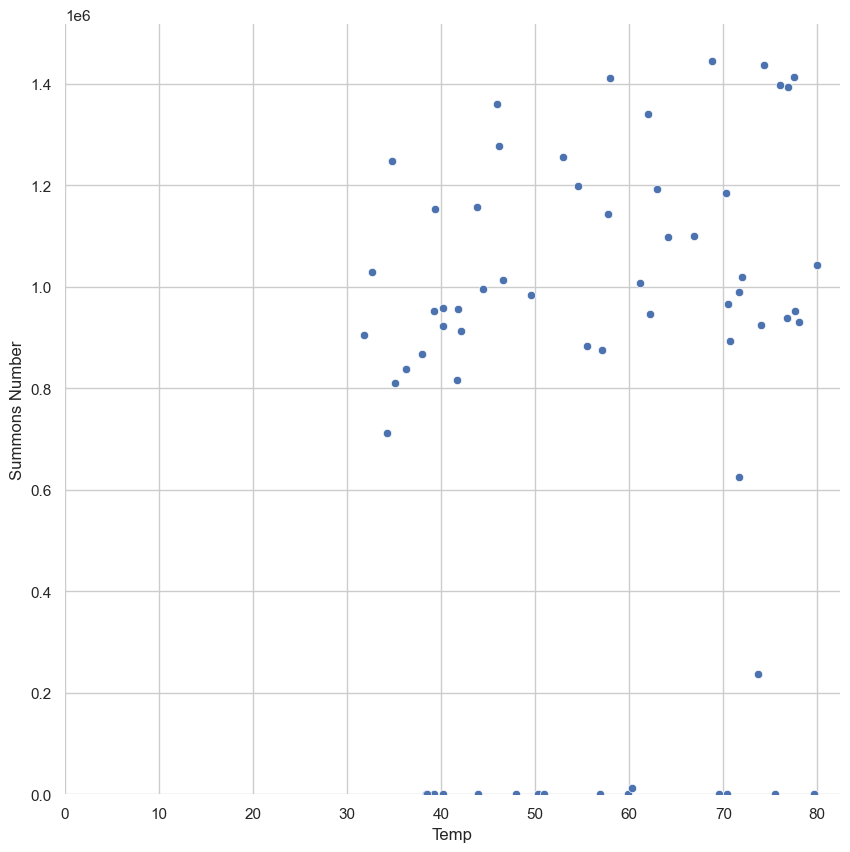

In [46]:
# Plot a scatter plot of Temp vs. Number of Citations
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="Temp", y="Summons Number",
data=citationsAndTemps.compute(), ax=ax)
plt.ylim(ymin=0)
plt.xlim(xmin=0)

(0.0, 82.41)

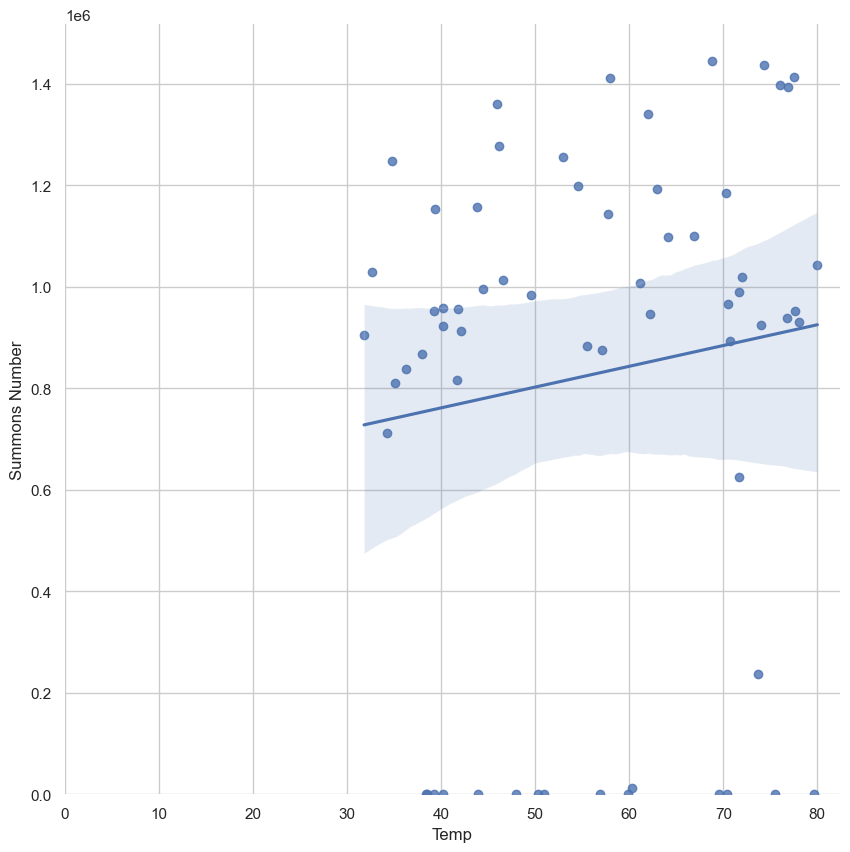

In [9]:
#RegPlot

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.regplot(x="Temp", y="Summons Number",
data=citationsAndTemps.compute(), ax=ax,
robust=True)
plt.ylim(ymin=0)
plt.xlim(xmin=0)

(0.0, 82.41)

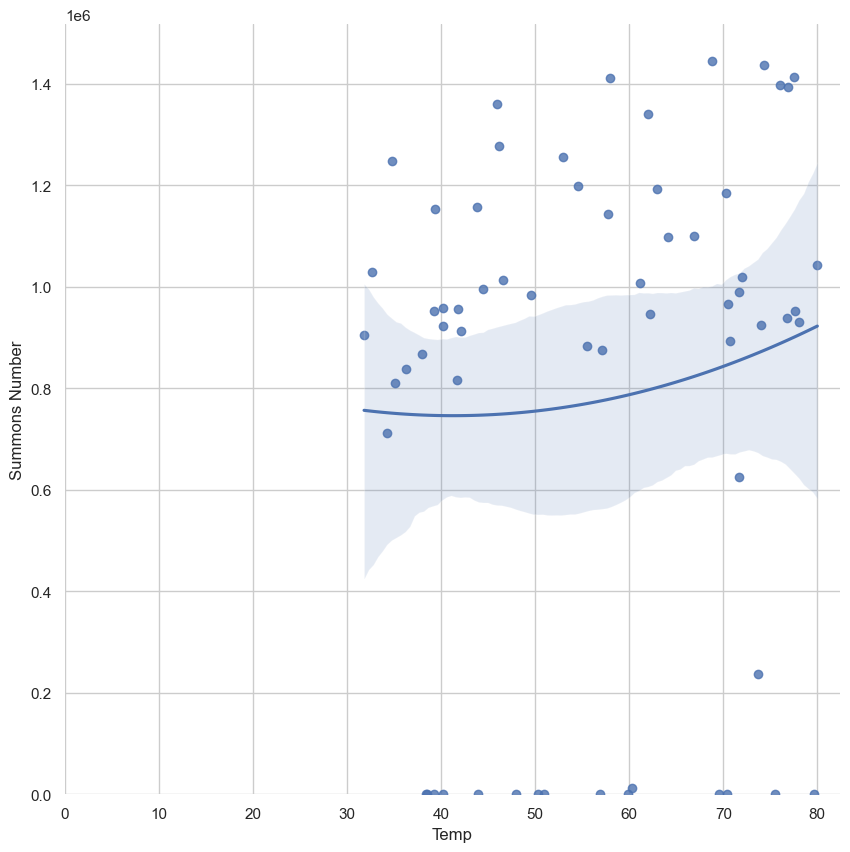

In [11]:
# Try a non-linear fit by setting the order parameter # to 2 (roughly parabolic shape)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.regplot(x="Temp", y="Summons Number",
data=citationsAndTemps.compute(), ax=ax,
order=2)
plt.ylim(ymin=0)
plt.xlim(xmin=0)

In [12]:
nyc_data_with_vehicle_age = dd.read_parquet('s3://activity2bucket2/transformed_data_till_3j_question/*.parquet',engine="pyarrow",storage_options={'key':os.environ["AWS_ACCESS_KEY_ID"],
                                                'secret':os.environ["AWS_SECRET_ACCESS_KEY"],
                                                 'token':os.environ["AWS_SESSION_TOKEN"]
                                                })
row_filter = nyc_data_with_vehicle_age['Vehicle Color'].isin(['BLACK','WHITE','GREY','RED','GREEN','BLUE'])
column_filter = ['Vehicle Age','Vehicle Color']
ages_and_colors = nyc_data_with_vehicle_age[row_filter][column_filter]

In [13]:
print(ages_and_colors.count().compute())

Vehicle Age      3098314
Vehicle Color    3098314
dtype: int64


/var/folders/s4/pc8pbq8935s2p_shty3w1p3m0000gn/T/ipykernel_8872/2194420008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Vehicle Color", y="Vehicle Age",


<AxesSubplot:xlabel='Vehicle Color', ylabel='Vehicle Age'>

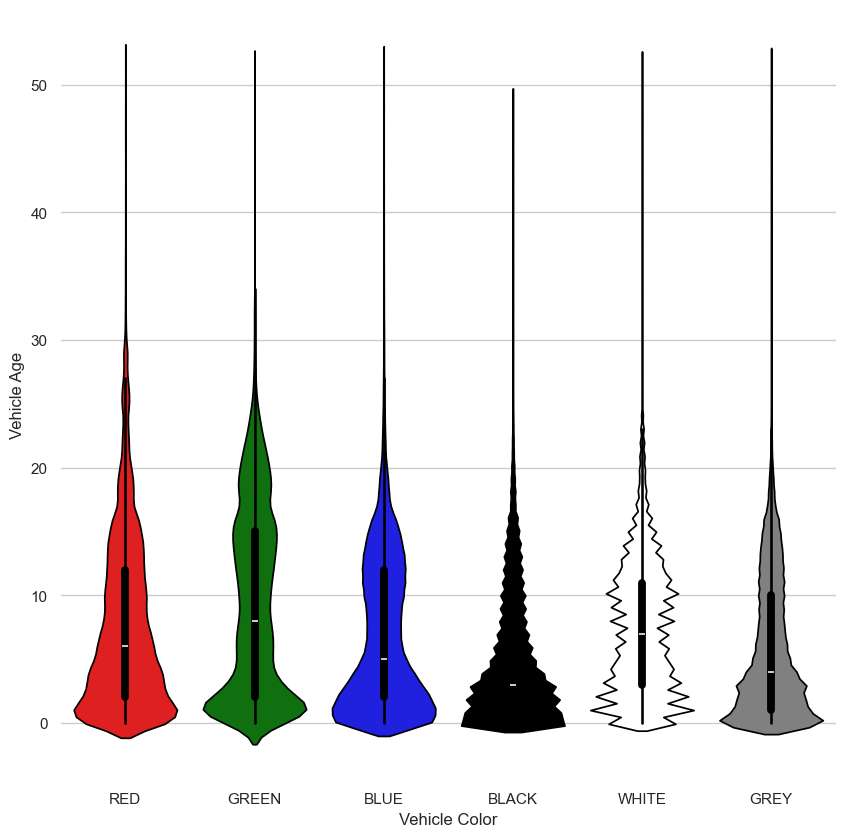

In [14]:
# Plot a violinplot to show the distributions of # vehicle ages grouped by vehicle color
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
group_order = ["RED", "GREEN", "BLUE", "BLACK",
"WHITE", "GREY"]
sns.violinplot(x="Vehicle Color", y="Vehicle Age",
data=ages_and_colors.compute(), order=group_order,
palette=group_order, ax=ax)

/var/folders/s4/pc8pbq8935s2p_shty3w1p3m0000gn/T/ipykernel_8872/4204352690.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Vehicle Color", y="Vehicle Age",


<AxesSubplot:xlabel='Vehicle Color', ylabel='Vehicle Age'>

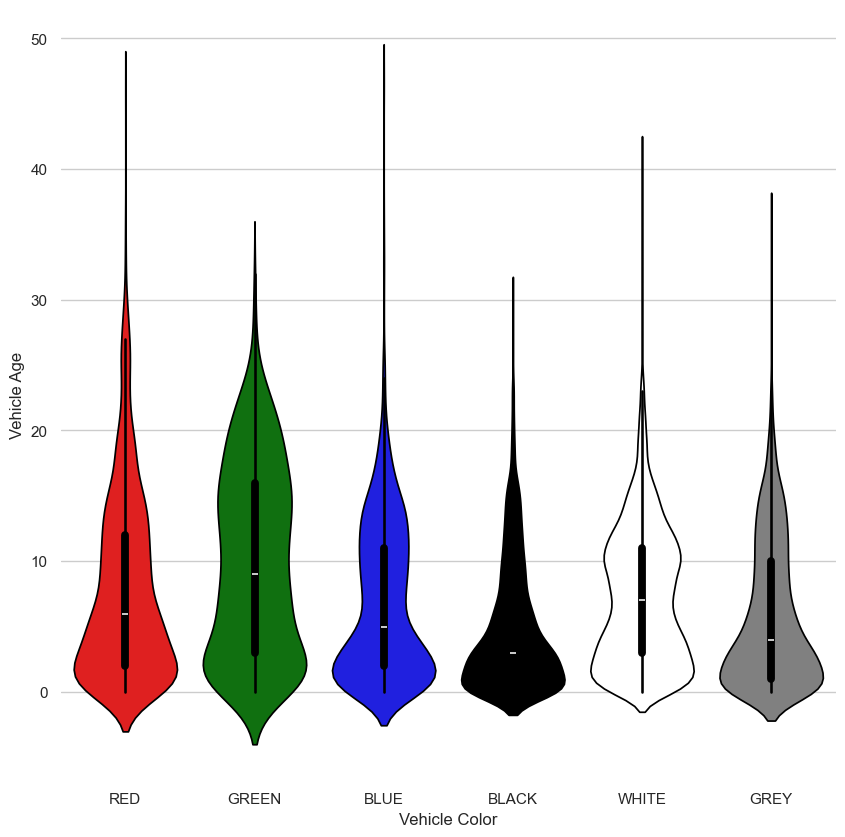

In [15]:
# Plot a violinplot of a random sample
sample = ages_and_colors.sample(frac=0.01)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.violinplot(x="Vehicle Color", y="Vehicle Age",
data=sample.compute(), order=group_order,
palette=group_order,
ax=ax)